In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
links = pd.read_csv('data/links.csv')
MOVIES = pd.read_csv('data/movies.csv')
RATINGS = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

## EDA

In [ ]:
print('Кол-во уникальных пользователей: {}\nКол-во фильмов: {}'.format(RATINGS['userId'].nunique(),
                                                                        RATINGS['movieId'].nunique()))

Кол-во уникальных пользователей: 610
Кол-во фильмов: 9724


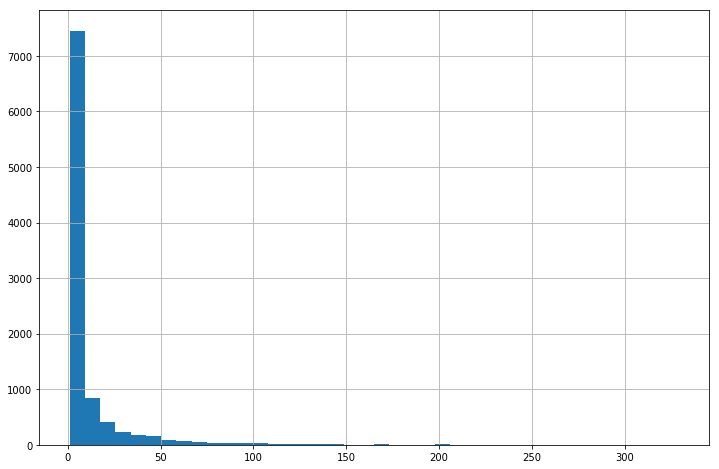

In [ ]:
x = RATINGS['movieId'].value_counts()
x.hist(bins = 40, figsize=(12,8))

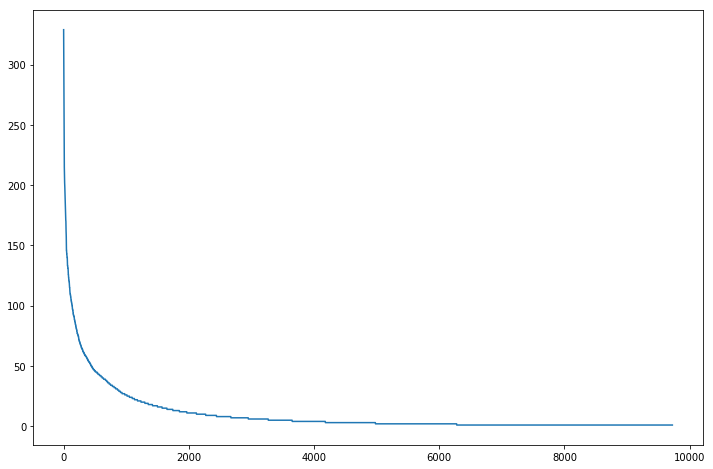

In [ ]:
#на оси Y кол-во оценок для конкретного фильма, на оси x индекси фильмов
plt.figure(figsize=(12,8))
plt.plot(x.reset_index(drop=True))

Берем только те фильмы, которые были оценены больше 100 пользователями

In [ ]:
x = x[x>100]

In [ ]:
# отфилтрируем из из общей таблицы
RATINGS = RATINGS[RATINGS['movieId'].isin(x.index)]
RATINGS.shape

(19788, 4)

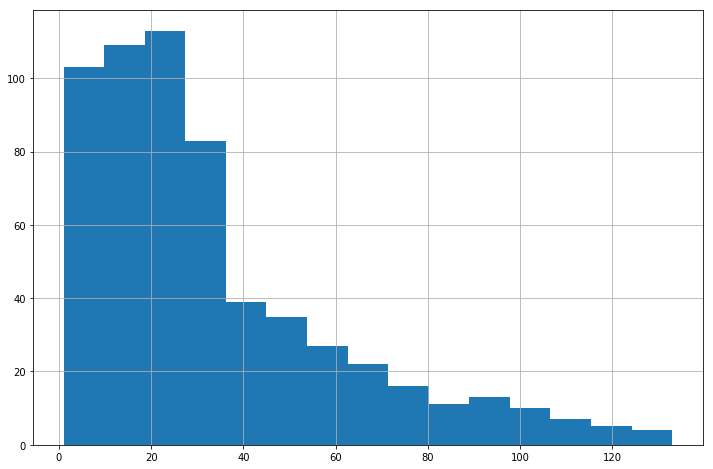

In [ ]:
x = RATINGS['userId'].value_counts()
x.hist(bins = 15, figsize=(12,8))

In [ ]:
# Берем только тех пользователей, которые оценили больше 10 филмов
x = x[x >= 10]
len(x)

494

In [ ]:
RATINGS = RATINGS[RATINGS['userId'].isin(x.index)]
RATINGS.shape

(19260, 4)

In [ ]:
n_users = RATINGS['userId'].nunique()
n_movies = RATINGS['movieId'].nunique()

In [ ]:
(n_users, n_movies)

(494, 134)

In [ ]:
train_data, test_data = train_test_split(RATINGS, test_size = 0.2)

In [ ]:
test_data.shape

(3852, 4)

метрика для проверки качества (среднеквадратическая ошибка)

In [ ]:
def rmse(prediction, ground_truth):
    # Оставим оценки, предсказанные алгоритмом, только для соотвествующего набора данных
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    # Оставим оценки, которые реально поставил пользователь, только для соотвествующего набора данных
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    
    mse = mean_squared_error(prediction, ground_truth)
    return sqrt(mse)

потроим таблицы рейтингов (user_item)

In [ ]:
train_user_item = train_data.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

test_user_item = test_data.pivot(    
    index = 'userId',
    columns = 'movieId',
    values = 'rating'
).fillna(0)
#храним индексы пользователей и фильмов
TRAIN_USER_ITEM_INDEX = train_user_item.index
TRAIN_USER_ITEM_COLUMNS = train_user_item.columns
TEST_USER_ITEM_INDEX = test_user_item.index
TEST_USER_ITEM_COLUMNS = test_user_item.columns

запишем наши таблицы в массивах

In [ ]:
train_user_item = np.array(train_user_item)
test_user_item = np.array(test_user_item)


матрицы коминусных расстоянии юзеров и филмов 

In [ ]:
user_similarity = pairwise_distances(train_user_item, metric='cosine')
item_similarity = pairwise_distances(train_user_item.T, metric='cosine')

In [ ]:
item_similarity.shape

(134, 134)

# Алгоритмы коллаборативной филтрации

### Наивные рекомендации

In [ ]:
# User-based collaborative filtering
def naive_predict_user(top):
    # Структура для хранения для каждого пользователя оценки фильмов top наиболее похожих на него пользователей:
    # top_similar_ratings[0][1] - оценки всех фильмов одного из наиболее похожих пользователей на пользователя с ид 0.
    # Здесь 1 - это не ид пользователя, а просто порядковый номер.
    top_similar_ratings = np.zeros((n_users, top, n_movies))
    for i in range(n_users):
        # Для каждого пользователя необходимо получить наиболее похожих пользователей:
        # Нулевой элемент не подходит, т.к. на этом месте находится похожесть пользователя самого на себя
        top_sim_users = user_similarity[i].argsort()[1:top + 1] #indices 
        
        # берём только оценки из "обучающей" выборки 
        # для каждого юзера подбирается рейтинги самих похожих ему пользователей
        top_similar_ratings[i] = train_user_item[top_sim_users]
    pred = np.zeros((n_users, n_movies))
    for i in range(n_users):
        #Для i-го пользователя вычисляем среднюю оценку по своим близким польз.
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred

# Item-based collaborative filtering
def naive_predict_item(top):
    top_similar_ratings = np.zeros((n_movies, top, n_users))

    for i in range(n_movies):
        top_sim_movies = item_similarity[i].argsort()[1:top + 1]
        top_similar_ratings[i] = train_user_item.T[top_sim_movies]
        
    pred = np.zeros((n_movies, n_users))
    for i in range(n_movies):
       
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred.T
        


Сравним точности

In [ ]:
rmse_user = rmse(naive_predict_user(30), test_user_item)
rmse_item = rmse(naive_predict_item(30), test_user_item)
print("User-based CF, rmse is: {}\nUser-based CF, rmse is: {}".format(rmse_user, rmse_item))

User-based CF, rmse is: 2.446204731764716
User-based CF, rmse is: 2.8661391311475826


### Рекомендации с учётом средних оценок похожих пользователей

[подробные комментарии ниже](#1)

In [ ]:
def k_fract_mean_predict(top):
    top_similar = np.zeros((n_users, top))
    
    for i in range(n_users):
        user_sim = user_similarity[i]
        top_sim_users = user_sim.argsort()[1:top + 1]

        for j in range(top):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(user_similarity)
    pred = np.zeros((n_users, n_movies))
    
    for i in range(n_users):
        indexes = top_similar[i].astype(np.int)
        numerator = user_similarity[i][indexes]
        
        mean_rating = np.array([x for x in train_user_item[i] if x > 0]).mean()
        diff_ratings = train_user_item[indexes] - train_user_item[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        
        pred[i] = mean_rating + numerator / denominator
        
    return pred

def k_fract_mean_predict_item(top):
    top_similar = np.zeros((n_movies, top))
    
    for i in range(n_movies):
        movie_sim = item_similarity[i]
        top_sim_movies = movie_sim.argsort()[1:top + 1]
        
        for j in range(top):
            top_similar[i, j] = top_sim_movies[j]
    
    abs_sim = np.abs(item_similarity)
    pred = np.zeros((n_movies, n_users))
    
    for i in range(n_movies):
        indexes = top_similar[i].astype(np.int)
        numerator = item_similarity[i][indexes]
        
        mean_rating = np.array([x for x in train_user_item.T[i] if x > 0]).mean()
        mean_rating = 0 if np.isnan(mean_rating) else mean_rating
        
        diff_ratings = train_user_item.T[indexes] - mean_rating
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        denominator = denominator if denominator != 0 else 1
        
        pred[i] = mean_rating + numerator / denominator
       
                
    return pred.T

Сравним точности

In [ ]:
k_predict = k_fract_mean_predict(30)
print('User-based CF RMSE: ', rmse(k_predict, train_user_item))

k_predict_item = k_fract_mean_predict_item(30)
print('Item-based CF RMSE: ', rmse(k_predict_item, test_user_item))


User-based CF RMSE:  1.2769154570315768
Item-based CF RMSE:  2.8721247543037873


### Дальше будем использовать алгоритмы рекомендации с учётом средних оценок похожих пользователей или филмов 

немножко модифицируем эти алгоритмы 

На вход принимает матрицу рейтингов, для которой нужно заполнить рейтинги по user_based СF, задаем также кол-во близких юзеров, возвращает матрицу рейтингов. #<a name="1"></a>

In [ ]:
def k_fract_mean_predict_user(users_ratings, k_neighbors=10):
    nus = len(users_ratings)
    #К основному матрицу рейтингов добавим входную матрицу рейтингов, (они добавляются в конец)
    user_item = np.append(train_user_item, users_ratings, axis=0) 
    # косинусное расстояние между юзерами
    similaritys = pairwise_distances(user_item, metric='cosine')
    #берем последние строки, т.е. которые мы добавили
    similaritys = similaritys[-nus:]
    top_similar = np.zeros((nus, k_neighbors))
    
    for i in range(nus):
        user_sim = similaritys[i].copy()
        #Сортирвка по возрастанию, чем меньше значении, тем объекты ближе, (берем первые k_neighbors близкие)
        top_sim_users = user_sim.argsort()[1:k_neighbors + 1]

        for j in range(k_neighbors):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(similaritys)
    pred = np.zeros((nus, n_movies))
    finish_pred = users_ratings.copy()
    for i in range(nus):
        indexes = top_similar[i].astype(np.int)
        numerator = similaritys[i][indexes]
        
        mean_rating = np.array([x for x in user_item[i] if x > 0]).mean()
        diff_ratings = user_item[indexes] - user_item[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        #все ячейки заполняются прогнозными рейтингами включая те, в которых раньше были рейтинги
        pred[i] = mean_rating + numerator / denominator
        #из таблицы, в которой предсказанные оценки, заполняем только те, где были нули
        finish_pred[i][np.nonzero(finish_pred[i]==0)] = pred[i][np.nonzero(finish_pred[i]==0)]
    return finish_pred


На вход принимает матрицу рейтингов, для которой нужно заполнить рейтинги по user_based СF, задаем также кол-во близких юзеров, возвращает матрицу рейтингов.

In [ ]:
def k_fract_mean_predict_item(users_ratings, k_neighbor_movies):
#     добавим входные рейтинги юзеров к общим рейтингам
    user_item = np.append(train_user_item, users_ratings, axis=0) 
    #кол-во входных юзеров
    nus = len(users_ratings)
    #общое кол-во юзеров
    all_users = len(user_item)
    #получим близости по item
    item_sim = pairwise_distances(user_item.T, metric='cosine')
    top_similar = np.zeros((n_movies, k_neighbor_movies))
    for i in range(n_movies):
        movie_sim = item_sim[i] 
        # храним индексы первых k_neighbor_movies близких фильмов
        top_sim_movies = movie_sim.argsort()[1:k_neighbor_movies + 1]
        #Для каждого фильма храним индексы своих близких
        for j in range(k_neighbor_movies):
            top_similar[i, j] = top_sim_movies[j]
    
    abs_sim = np.abs(item_sim)
    pred = np.zeros((n_movies, all_users))
    finish_pred = users_ratings.copy()
    for i in range(n_movies):
        indexes = top_similar[i].astype(np.int) 
        #берем рейтинги близких фильмов i-го фильма
        numerator = item_sim[i][indexes] # (n_movies, k_neghbor)
        # во всех строкх (фильмах) вычисляем среднюю оценку, пропуская 
        mean_rating = np.array([x for x in user_item.T[i] if x > 0]).mean()
        mean_rating = 0 if np.isnan(mean_rating) else mean_rating
        # Из рейтинов близких фильмов i-го фильма, отнимаем средний рейтинг i-го фильма
        diff_ratings = user_item.T[indexes] - mean_rating 
        # произведение матриц (рейтинги бликих фильмов i-го (1,k_neighbor) * diff_ratings (k_neighbor, n_suer )
        numerator = numerator.dot(diff_ratings)# (1, n_user)
        #сумма рейтингов близких фильмов i-го фильма
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        denominator = denominator if denominator != 0 else 1
        
        pred[i] = mean_rating + numerator / denominator
    pred = pred.T
    pred = pred[-nus:]
    for i in range(nus):
        #в входной матрице рейтингов, где были выставлены оценки их не рассмотриваем 
        finish_pred[i][np.nonzero(finish_pred[i]==0)] = pred[i][np.nonzero(finish_pred[i]==0)]    
                
    return finish_pred

функция рекомендации. На вход принимает матрицу рейтингов, заполняет по user-based или item-based cf и строит рекомендации

In [ ]:
def CF_recommendation(user_item,top_recommend=10, k_neighbors=30, based='user'):
#     Возвращает запольненную матрицу рейтингов
    if based == 'item':
        CF_ratings =k_fract_mean_predict_item(users_ratings=user_item, k_neighbor_movies=k_neighbors)
    else:
        CF_ratings = k_fract_mean_predict_user(users_ratings=user_item, k_neighbors=k_neighbors)
    #Кол-во пользователей, для которых хотим рекомендовать фильм
    n_user = len(CF_ratings)
    #Ключ-> пользователь, значение -> список фильмов
    user_recomm = {}
    for i in range(n_user):        
        #присвоим nan оценкам, котрые раньше были выставлены пользовательем, чтобы при сортировке оказались в конец
        #т.к. не хотим рекомендовать фильмы, которые пользователь уже оценил
        CF_ratings[i][np.where(test_user_item[i]!=0)]=np.nan
        #Сортировка индексов по убыванию, выбераем первые top_recommend
        arr_movie_index=(-CF_ratings[i]).argsort()[:top_recommend]
        # получим реальные ид фильмов 
        real_movie_index = list(TRAIN_USER_ITEM_COLUMNS[arr_movie_index])
        #Для каждого пользователья храним список рекоммендации
        user_recomm[i] = list(MOVIES[MOVIES['movieId'].isin(real_movie_index)]['title'])
    return pd.DataFrame(user_recomm)
    

In [ ]:
# названия столбцов - это индексы юзеров

In [ ]:
CF_recommendation(test_user_item[0:3], top_recommend=10, based='user') # based == user or item (default is user)

,0,1,2
0,"Shawshank Redemption, The (1994)",Star Wars: Episode IV - A New Hope (1977),Apollo 13 (1995)
1,Forrest Gump (1994),Pulp Fiction (1994),Batman Forever (1995)
2,Terminator 2: Judgment Day (1991),Jurassic Park (1993),Star Trek: Generations (1994)
3,"Silence of the Lambs, The (1991)",Terminator 2: Judgment Day (1991),Forrest Gump (1994)
4,Star Wars: Episode V - The Empire Strikes Back...,"Silence of the Lambs, The (1991)","Mask, The (1994)"
5,Raiders of the Lost Ark (Indiana Jones and the...,Fargo (1996),True Lies (1994)
6,Aliens (1986),"Godfather, The (1972)","Firm, The (1993)"
7,Star Wars: Episode VI - Return of the Jedi (1983),Monty Python and the Holy Grail (1975),"Fugitive, The (1993)"
8,"Sixth Sense, The (1999)",Star Wars: Episode VI - Return of the Jedi (1983),Jurassic Park (1993)
9,"Lord of the Rings: The Fellowship of the Ring,...","Matrix, The (1999)","Silence of the Lambs, The (1991)"
